# qGANs for Loading Random Distributions

Quantum algorithms have the potential to outperform their classical counterparts in a variety of tasks. The realization of theadvantage often requires the ability to load classical data efficiently into quantum states. However, the best known methods require $\mathcal{O}(2^n)$ gates to load an exact representation of a generic data structure into an $n$-qubit state. 

-----

This tutorial will present a hybrid quantum-classical algorithm for **efficient** and **approximate** quantum state loading. 

------

**qGAN** can learn a representation of the probability distribution underlying the data samples and load it into a quantum state. The complexity is $\mathcal{O}(\text{poly}(n))$


## What's in the name?

The generative model employ two *neural networks* - a **generator** and a **discriminator** to learn random distributions that are implicitly given by training data samples.

-----

Suppose a classical training data set $X = \{x^0, ....., x^{s-1}\} \subset \mathbb{R}^{k_{out}}$ sampled from an unknown probability distribution $p_{real}$.

Let $G_{\theta} : \mathbb{R}^{k_{in}} → \mathbb{R}^{k_{out}}$ and $D_{\phi} : \mathbb{R}^{k_{out}} → \{0,1\}$ denote the generator and the discriminator networks. 

-----

The generator $G_{\theta}$  translates the samples from a fixed prior distribution into samples which are indistinguishable from the samples of the real distribution.

The discriminator $D_{\phi}$ tries to distinguish between data from the generator and the training set.

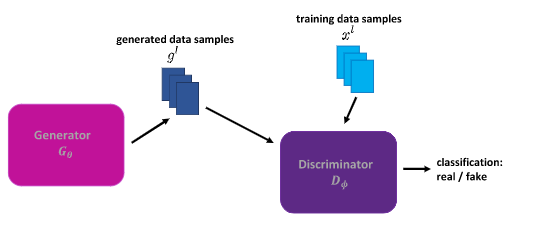

Generative Adversarial Network. First, the generator createsdata samples which shall be indistinguishable from the trainingdata. Second, the discriminator tries to differentiate between thegenerated samples and the training samples. The generator anddiscriminator are trained alternately

## qGAN distribution learning

The qGAN implementation here uses a quantum generator and a classical discriminator to capture the probability distribution of classical training samples.

-----

A parameterized quantum channel i.e the **quantum generator** is trained to transform a given $n$-qubit input state $|\psi_{in}⟩$ to an $n$- qubit output state

$$ G_{\theta} |\psi_{in}⟩ = |g_{\theta}⟩ = \sum_{i=0}^{N-1} \sqrt{p_{\theta}^i} |i⟩$$

where $p_{\theta}^i$ describe the resulting occurenece probabilities of the basis states $|i⟩$.

-----

The quantum generator is implemented by a *variational form* (parameterized quantum circuit). The circuit consists of a first layer of $RY$ gates, and then $k$ alternating repetitions of $U_{ent}$ and further layers of $RY$ gates

The rotation acting is controled bby the parameter $\theta$, the parameter $k$ is called the depth of the variational circuit. 

**If such variational circuit acts in $n$ qubits it uses in total $(k+1)n$ parameterized single qubit gates and $kn$ two qubit gates.


------

The reason for only chosing the $RY$ and $CZ$ gates in contrast to other Pauli Rotations and two qubti gates, is that for $\theta = 0$, the variational form has no effect on the state amplitude, but only flips the phases.

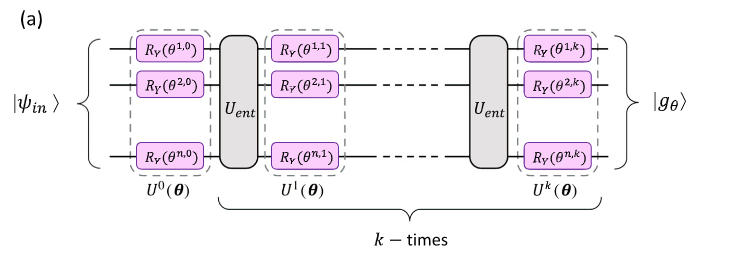

Quantum Generator. The variational from with depth $k$ acts on $n$ qubits. It is composed of $k+1$ layers of single-qubit Pauli-Y rotations and $k$ entangling blocks $U_{ent}$

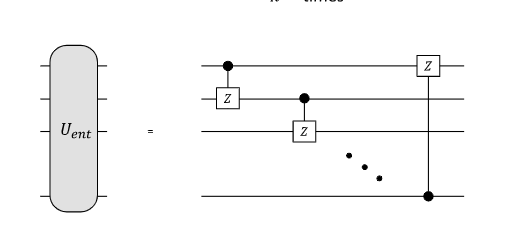

Each entangling block applies $CZ$ gates from qubit $i$ to qubit $i+1$ mod $n$ to create entanglement between the different qubits.

In [1]:
%pip install qiskit[finance]
%pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.3/241.3 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 KB

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import Aer, QuantumRegister, QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Statevector

from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_finance.applications.estimation import EuropeanCallPricing
from qiskit_finance.circuit.library import NormalDistribution
from qiskit_finance.circuit.library import LogNormalDistribution

In [3]:
# Set upper and lower data values
bounds = np.array([0.0, 15.0])
# Set number of qubits used in the uncertainty model
num_qubits = 6

# Load the trained circuit parameters
# the number of params should be 2*num_qubits
g_params = [0.381330,0.756949,0.756450, 0.820512 ,0.712807,0.568182 ,0.602626428, 0.13537225,  0.2347225 , 0.6547225, 0.722245, 0.252345]

# Set an initial state for the generator circuit
init_dist = LogNormalDistribution(num_qubits, mu=4.25, sigma=1.25, bounds=bounds)

# construct the variational form
var_form = TwoLocal(num_qubits, "ry", "cz", entanglement="circular", reps=1)

# keep a list of the parameters so we can associate them to the list of numerical values
# (otherwise we need a dictionary)
theta = var_form.ordered_parameters

# compose the generator circuit, this is the circuit loading the uncertainty model
g_circuit = init_dist.compose(var_form)

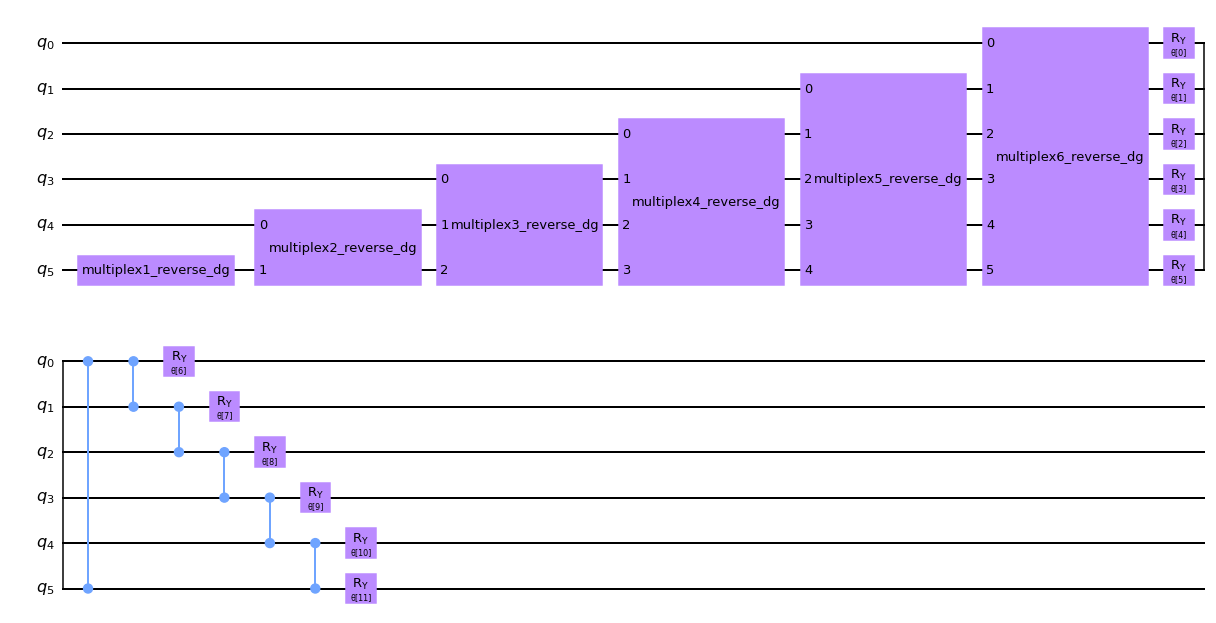

In [4]:
g_circuit.decompose().draw('mpl')

In [5]:
g_circuit.values

array([ 0.        ,  0.23809524,  0.47619048,  0.71428571,  0.95238095,
        1.19047619,  1.42857143,  1.66666667,  1.9047619 ,  2.14285714,
        2.38095238,  2.61904762,  2.85714286,  3.0952381 ,  3.33333333,
        3.57142857,  3.80952381,  4.04761905,  4.28571429,  4.52380952,
        4.76190476,  5.        ,  5.23809524,  5.47619048,  5.71428571,
        5.95238095,  6.19047619,  6.42857143,  6.66666667,  6.9047619 ,
        7.14285714,  7.38095238,  7.61904762,  7.85714286,  8.0952381 ,
        8.33333333,  8.57142857,  8.80952381,  9.04761905,  9.28571429,
        9.52380952,  9.76190476, 10.        , 10.23809524, 10.47619048,
       10.71428571, 10.95238095, 11.19047619, 11.42857143, 11.66666667,
       11.9047619 , 12.14285714, 12.38095238, 12.61904762, 12.85714286,
       13.0952381 , 13.33333333, 13.57142857, 13.80952381, 14.04761905,
       14.28571429, 14.52380952, 14.76190476, 15.        ])

In [6]:
g_circuit.probabilities

array([0.00000000e+00, 1.01942879e-05, 9.83939593e-05, 3.10132199e-04,
       6.46626510e-04, 1.09237110e-03, 1.62774436e-03, 2.23371594e-03,
       2.89342414e-03, 3.59252505e-03, 4.31907232e-03, 5.06323775e-03,
       5.81700004e-03, 6.57385194e-03, 7.32854279e-03, 8.07685971e-03,
       8.81544461e-03, 9.54164267e-03, 1.02533774e-02, 1.09490480e-02,
       1.16274445e-02, 1.22876784e-02, 1.29291252e-02, 1.35513772e-02,
       1.41542043e-02, 1.47375216e-02, 1.53013626e-02, 1.58458570e-02,
       1.63712122e-02, 1.68776978e-02, 1.73656327e-02, 1.78353748e-02,
       1.82873117e-02, 1.87218536e-02, 1.91394270e-02, 1.95404695e-02,
       1.99254257e-02, 2.02947438e-02, 2.06488724e-02, 2.09882582e-02,
       2.13133443e-02, 2.16245681e-02, 2.19223606e-02, 2.22071452e-02,
       2.24793364e-02, 2.27393401e-02, 2.29875523e-02, 2.32243591e-02,
       2.34501367e-02, 2.36652508e-02, 2.38700570e-02, 2.40649004e-02,
       2.42501160e-02, 2.44260284e-02, 2.45929524e-02, 2.47511929e-02,
      

## Visualizing the Distribution

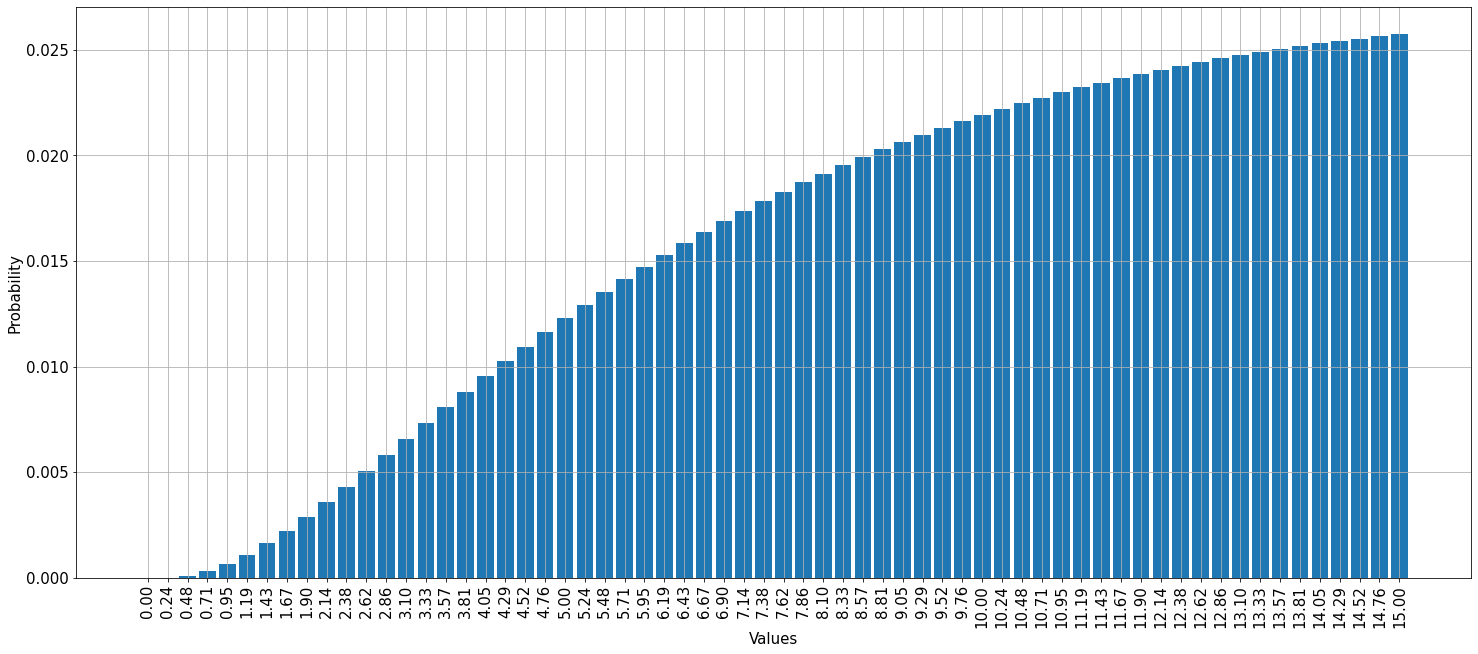

In [7]:

plt.rcParams["figure.figsize"] = (25,10.5)
x = g_circuit.values
y = g_circuit.probabilities
plt.bar(x,y, width=0.2)
plt.xticks(x,size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Values", size = 15)
plt.ylabel("Probability", size=15)
plt.show()

## Evaluate the Expected Payoff

Now, we have trained the uncertainty model


In [8]:
# setting the strike price

strike_price = 12.90

# approximation scaling

c_approx = 0.20

## Plot it

We plot the trained distribution and also the target probability distribution

In [9]:
# evaluaethe training

values = [bounds[0] + (bounds[1] - bounds[0]) * x / (2**num_qubits - 1) for x in range(2**num_qubits)]


In [10]:
# priniting the grid values
print(values)

[0.0, 0.23809523809523808, 0.47619047619047616, 0.7142857142857143, 0.9523809523809523, 1.1904761904761905, 1.4285714285714286, 1.6666666666666667, 1.9047619047619047, 2.142857142857143, 2.380952380952381, 2.619047619047619, 2.857142857142857, 3.0952380952380953, 3.3333333333333335, 3.5714285714285716, 3.8095238095238093, 4.0476190476190474, 4.285714285714286, 4.523809523809524, 4.761904761904762, 5.0, 5.238095238095238, 5.476190476190476, 5.714285714285714, 5.9523809523809526, 6.190476190476191, 6.428571428571429, 6.666666666666667, 6.904761904761905, 7.142857142857143, 7.380952380952381, 7.619047619047619, 7.857142857142857, 8.095238095238095, 8.333333333333334, 8.571428571428571, 8.80952380952381, 9.047619047619047, 9.285714285714286, 9.523809523809524, 9.761904761904763, 10.0, 10.238095238095237, 10.476190476190476, 10.714285714285714, 10.952380952380953, 11.19047619047619, 11.428571428571429, 11.666666666666666, 11.904761904761905, 12.142857142857142, 12.380952380952381, 12.619047

In [11]:
uncertainty_model = g_circuit.assign_parameters(dict(zip(theta, g_params)))



In [12]:
amplitudes = Statevector.from_instruction(uncertainty_model).data

In [13]:
# make arrays of the values and amplitudes
x = np.array(values)
y = np.abs(amplitudes) ** 2 # square of the amplitude is theprobability


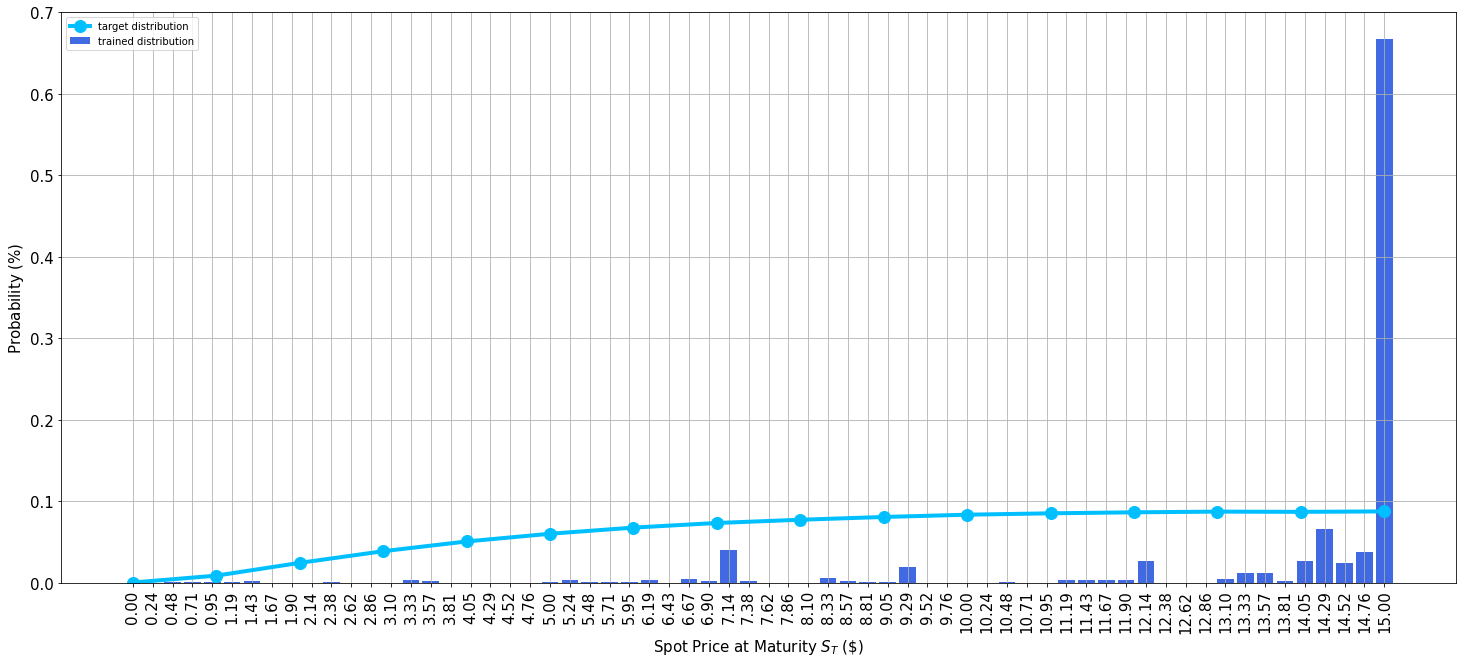

In [14]:
# sample from target probability 
N = 10000000
log_normal = np.random.lognormal(mean=4.25, sigma=1.25, size=N)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= 15]
log_normal_samples = []
for i in range(16):
    log_normal_samples += [np.sum(log_normal == i)]
log_normal_samples = np.array(log_normal_samples / sum(log_normal_samples))

# Plot distributions
plt.bar(x, y, width=0.2, label="trained distribution", color="royalblue")
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.plot(
    log_normal_samples,
    "-o",
    color="deepskyblue",
    label="target distribution",
    linewidth=4,
    markersize=12,
)
plt.legend(loc="best")
plt.show()

## Reduce the  number of qubits

In [15]:
# Set upper and lower data values
bounds = np.array([0.0, 10.0])
# Set number of qubits used in the uncertainty model
num_qubits = 3

# Load the trained circuit parameters
# the number of params should be 2*num_qubits
g_params = [0.602626428, 0.13537225,  0.2347225 , 0.6547225, 0.722245, 0.252345]

# Set an initial state for the generator circuit
init_dist = NormalDistribution(num_qubits, mu=4.0, sigma=2.25, bounds=bounds)

# construct the variational form
var_form = TwoLocal(num_qubits, "ry", "cz", entanglement="circular", reps=1)

# keep a list of the parameters so we can associate them to the list of numerical values
# (otherwise we need a dictionary)
theta = var_form.ordered_parameters

# compose the generator circuit, this is the circuit loading the uncertainty model
g_circuit = init_dist.compose(var_form)

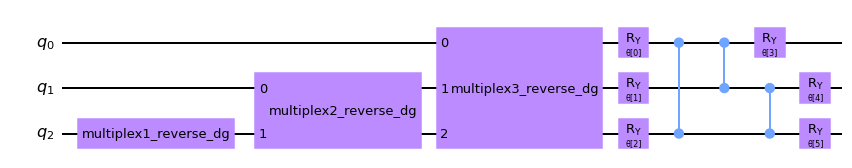

In [16]:
g_circuit.decompose().draw('mpl')

## Visualizing 

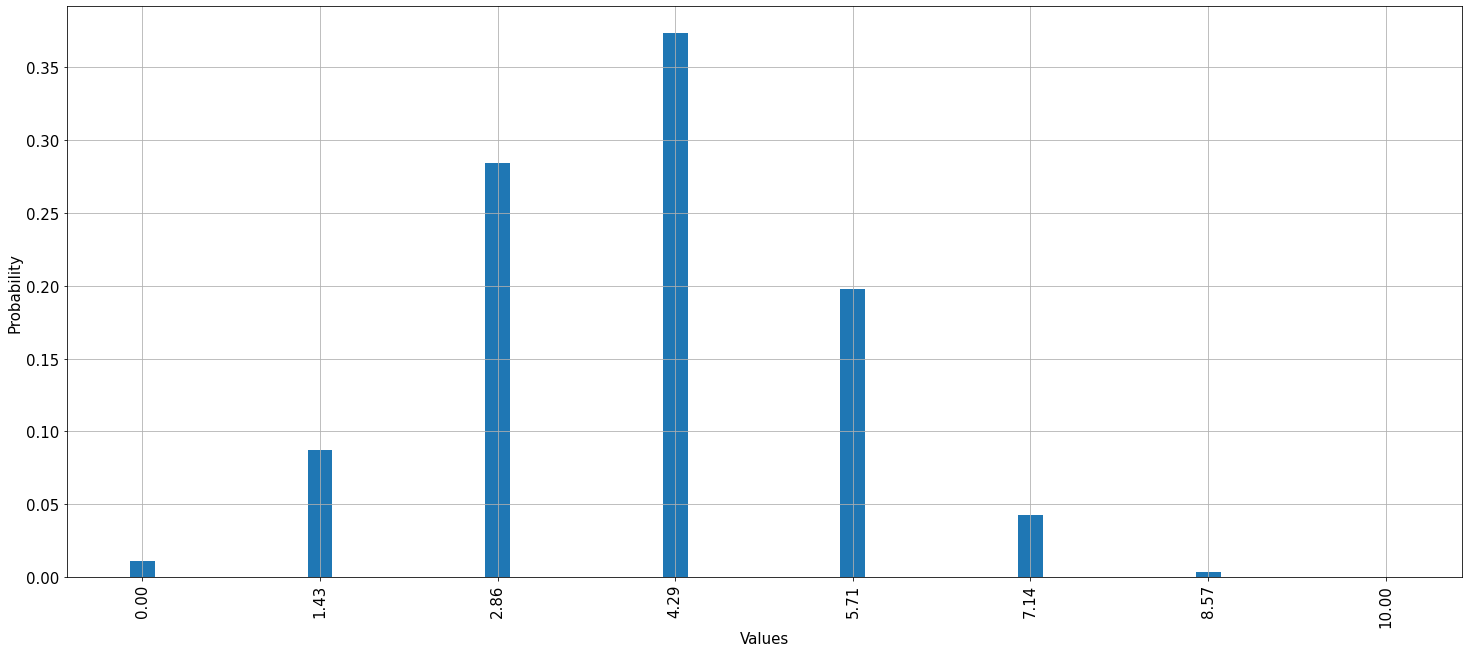

In [17]:

plt.rcParams["figure.figsize"] = (25,10.5)
x = g_circuit.values
y = g_circuit.probabilities
plt.bar(x,y, width=0.2)
plt.xticks(x,size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Values", size = 15)
plt.ylabel("Probability", size=15)
plt.show()

## Evaluate the Expected value

In [18]:
# setting the strike price

strike_price = 2.8

# approximation scaling

c_approx = 0.20

## Plot it

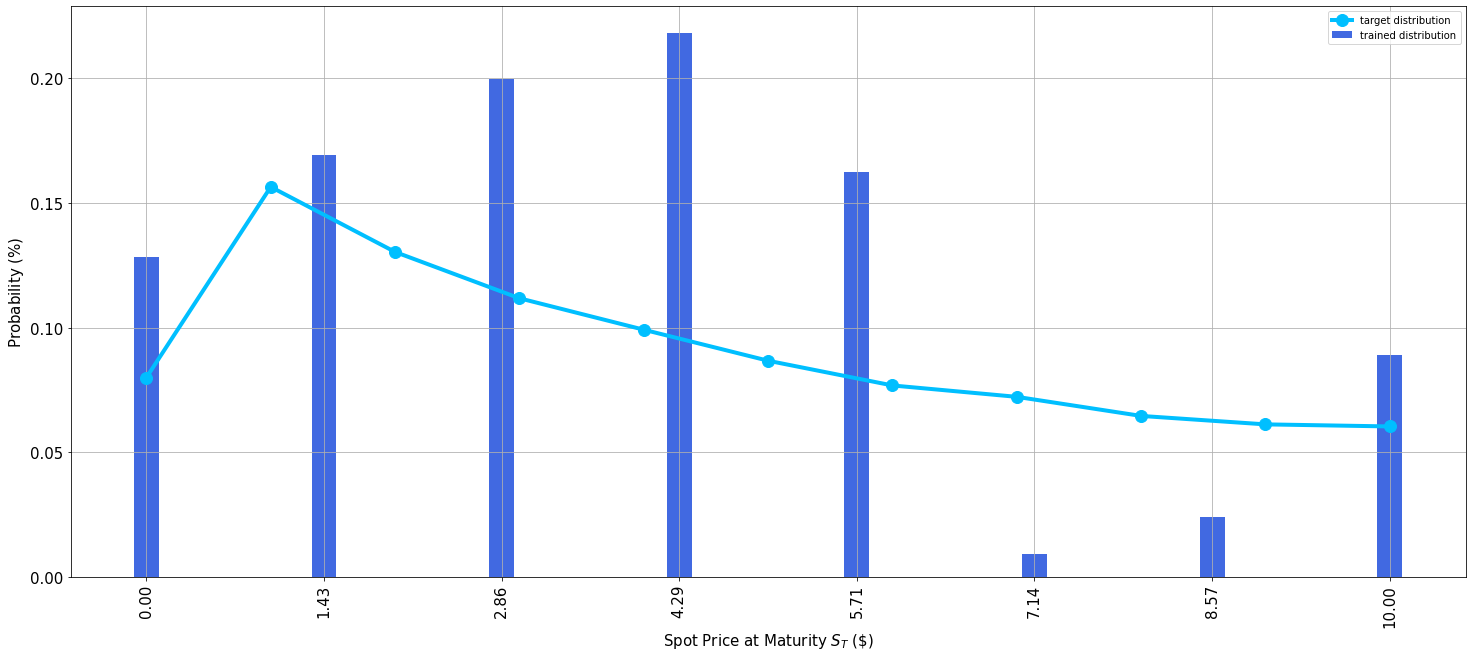

In [19]:
# evaluaethe training

values = [bounds[0] + (bounds[1] - bounds[0]) * x / (2**num_qubits - 1) for x in range(2**num_qubits)]
uncertainty_model = g_circuit.assign_parameters(dict(zip(theta, g_params)))
amplitudes = Statevector.from_instruction(uncertainty_model).data

x = np.array(values)
y = np.abs(amplitudes) ** 2

# Sample from target probability distribution
N = 100000
log_normal = np.random.lognormal(mean=4, sigma=2.25, size=N)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= 10]
log_normal_samples = []
for i in range(11):
    log_normal_samples += [np.sum(log_normal == i)]
log_normal_samples = np.array(log_normal_samples / sum(log_normal_samples))

# Plot distributions
plt.bar(x, y, width=0.2, label="trained distribution", color="royalblue")
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.plot(
    log_normal_samples,
    "-o",
    color="deepskyblue",
    label="target distribution",
    linewidth=4,
    markersize=12,
)
plt.legend(loc="best")
plt.show()


## Make further changes

#### Parameters for the distribution

In [20]:
# Set upper and lower data values
# the data will be between these two numbers

bounds = np.array([0.0, 17.0])
# Set number of qubits used in the uncertainty model
num_qubits = 5

# Load the trained circuit parameters
# the number of params should be 2*num_qubits
g_params = [0.756450, 0.820512 ,0.712807,0.568182 ,0.602626428, 0.13537225,  0.2347225 , 0.6547225, 0.722245, 0.252345]

# Set an initial state for the generator circuit
init_dist = NormalDistribution(num_qubits, mu=14.25, sigma=8.25, bounds=bounds)

# construct the variational form
var_form = TwoLocal(num_qubits, "ry", "cz", entanglement="circular", reps=1)

# keep a list of the parameters so we can associate them to the list of numerical values
# (otherwise we need a dictionary)
theta = var_form.ordered_parameters

# compose the generator circuit, this is the circuit loading the uncertainty model
g_circuit = init_dist.compose(var_form)

In [21]:
theta

[ParameterVectorElement(θ[0]),
 ParameterVectorElement(θ[1]),
 ParameterVectorElement(θ[2]),
 ParameterVectorElement(θ[3]),
 ParameterVectorElement(θ[4]),
 ParameterVectorElement(θ[5]),
 ParameterVectorElement(θ[6]),
 ParameterVectorElement(θ[7]),
 ParameterVectorElement(θ[8]),
 ParameterVectorElement(θ[9])]

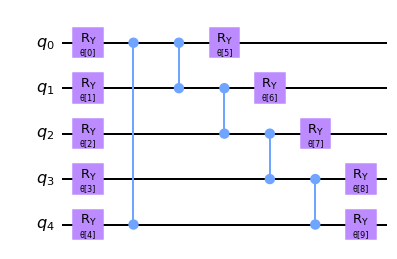

In [22]:
var_form.decompose().draw('mpl')

$\theta$ parameters are given by `g_params` 

We will need twice the number of parameters of the number of qubits given.

----

The `two_local` form will make the entangling layers.

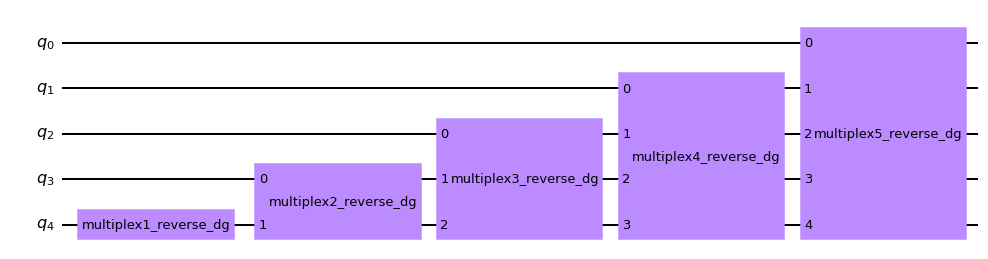

In [23]:
init_dist.decompose().draw('mpl')

In [24]:
from qiskit.compiler import transpile
from qiskit.tools.visualization import circuit_drawer

transpiled_qc = transpile(init_dist, backend=Aer.get_backend('qasm_simulator'))

# Draw the transpiled circuit
circuit_drawer(transpiled_qc)


┌────────────┐                                                  »
q_0: ┤ Ry(1.7582) ├──────────────────────────────────────────────────»
     ├────────────┤                                                  »
q_1: ┤ Ry(1.9236) ├──────────────────────────────────────────────────»
     ├───────────┬┘                         ┌───┐┌─────────────┐┌───┐»
q_2: ┤ Ry(2.163) ├──────────────────────────┤ X ├┤ Ry(0.20807) ├┤ X ├»
     ├───────────┴┐┌───┐┌─────────────┐┌───┐└─┬─┘└─────────────┘└─┬─┘»
q_3: ┤ Ry(2.4084) ├┤ X ├┤ Ry(0.54237) ├┤ X ├──■───────────────────┼──»
     ├────────────┤└─┬─┘└─────────────┘└─┬─┘                      │  »
q_4: ┤ Ry(2.8157) ├──■───────────────────■────────────────────────■──»
     └────────────┘                                                  »
«                                                                         »
«q_0: ────────────────────────────────────────────────────────────────────»
«                                               ┌───┐┌──────────────┐┌───┐»
«q_1: ──────────────────────────────────────────┤ X ├┤ Ry(0.064833) ├┤ X ├»
«     ┌───────────────┐┌───┐┌─────────────┐┌───┐└─┬─┘└──────────────┘└─┬─┘»
«q_2: ┤ Ry(-0.063216) ├┤ X ├┤ Ry(0.42617) ├┤ X ├──■────────────────────┼──»
«     └───────────────┘└─┬─┘└─────────────┘└─┬─┘                       │  »
«q_3: ───────────────────■───────────────────┼─────────────────────────■──»
«                                            │                            »
«q_4: ───────────────────────────────────────■────────────────────────────»
«                                                                         »
«                                                                      »
«q_0: ─────────────────────────────────────────────────────────────────»
«     ┌────────────────┐┌───┐┌─────────────┐┌───┐┌───────────────┐┌───┐»
«q_1: ┤ Ry(-0.0028886) ├┤ X ├┤ Ry(0.13013) ├┤ X ├┤ Ry(-0.012924) ├┤ X ├»
«     └────────────────┘└─┬─┘└─────────────┘└─┬─┘└───────────────┘└─┬─┘»
«q_2: ────────────────────■───────────────────┼─────────────────────■──»
«                                             │                        »
«q_3: ────────────────────────────────────────┼────────────────────────»
«                                             │                        »
«q_4: ────────────────────────────────────────■────────────────────────»
«                                                                      »
«                                                                       ┌───┐»
«q_0: ──────────────────────────────────────────────────────────────────┤ X ├»
«     ┌────────────────┐┌───┐┌────────────────┐┌───┐┌─────────────┐┌───┐└─┬─┘»
«q_1: ┤ Ry(-0.0019817) ├┤ X ├┤ Ry(-0.0063304) ├┤ X ├┤ Ry(0.26427) ├┤ X ├──■──»
«     └────────────────┘└─┬─┘└────────────────┘└─┬─┘└─────────────┘└─┬─┘     »
«q_2: ────────────────────┼──────────────────────■───────────────────┼───────»
«                         │                                          │       »
«q_3: ────────────────────■──────────────────────────────────────────┼───────»
«                                                                    │       »
«q_4: ───────────────────────────────────────────────────────────────■───────»
«                                                                            »
«     ┌──────────────┐┌───┐┌─────────────────┐┌───┐┌──────────────┐┌───┐»
«q_0: ┤ Ry(0.017669) ├┤ X ├┤ Ry(-0.00011553) ├┤ X ├┤ Ry(0.035349) ├┤ X ├»
«     └──────────────┘└─┬─┘└─────────────────┘└─┬─┘└──────────────┘└─┬─┘»
«q_1: ──────────────────┼───────────────────────■────────────────────┼──»
«                       │                                            │  »
«q_2: ──────────────────■────────────────────────────────────────────┼──»
«                                                                    │  »
«q_3: ───────────────────────────────────────────────────────────────■──»
«                                                                       »
«q_4: ────────────────────────────────────────────

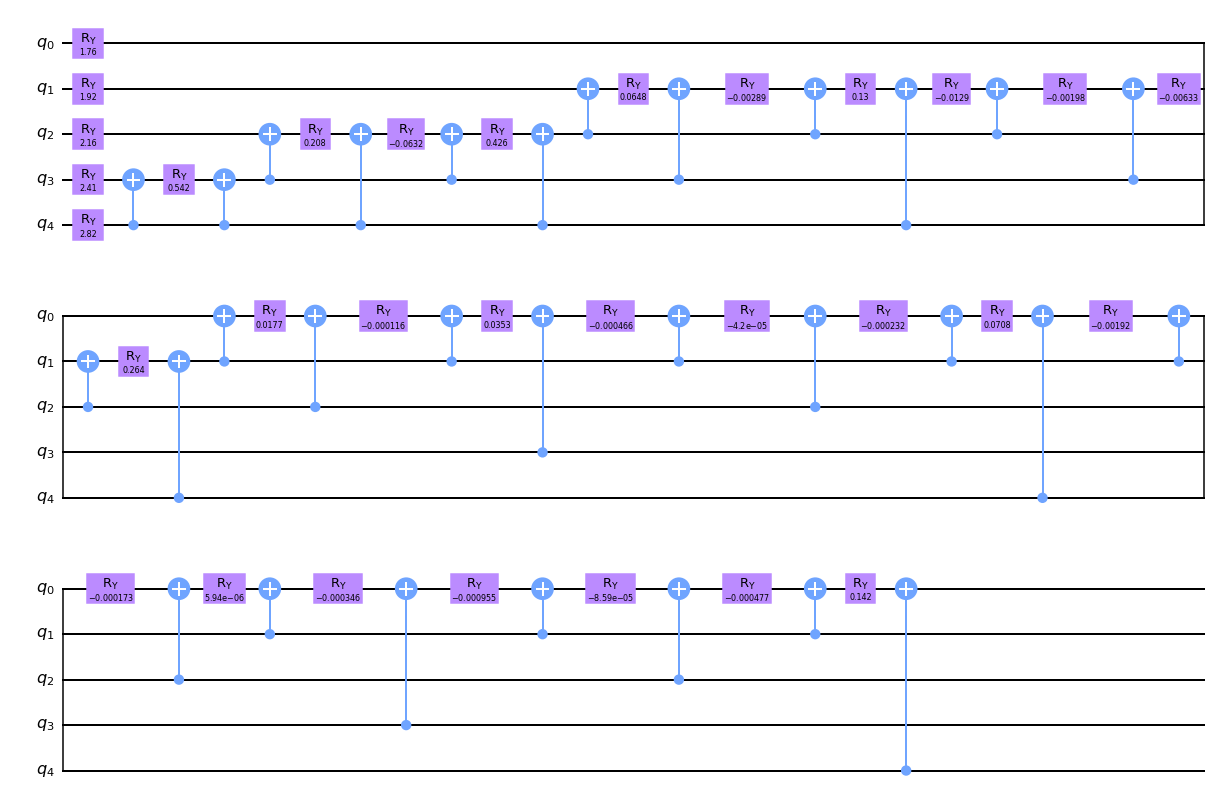

In [25]:
transpiled_qc.draw('mpl')

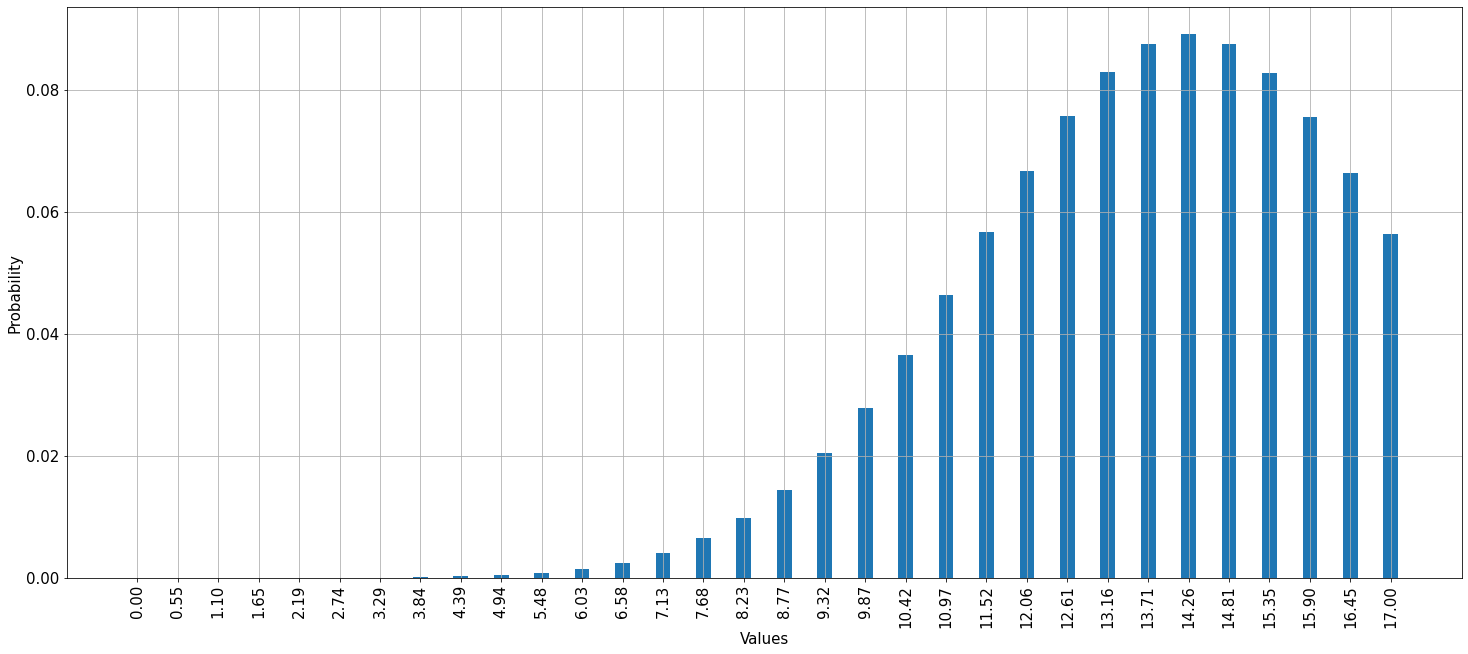

In [26]:

plt.rcParams["figure.figsize"] = (25,10.5)
x = g_circuit.values
y = g_circuit.probabilities
plt.bar(x,y, width=0.2)
plt.xticks(x,size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Values", size = 15)
plt.ylabel("Probability", size=15)
plt.show()

In [27]:
# setting the strike price

strike_price = 15.8

# approximation scaling

c_approx = 0.20

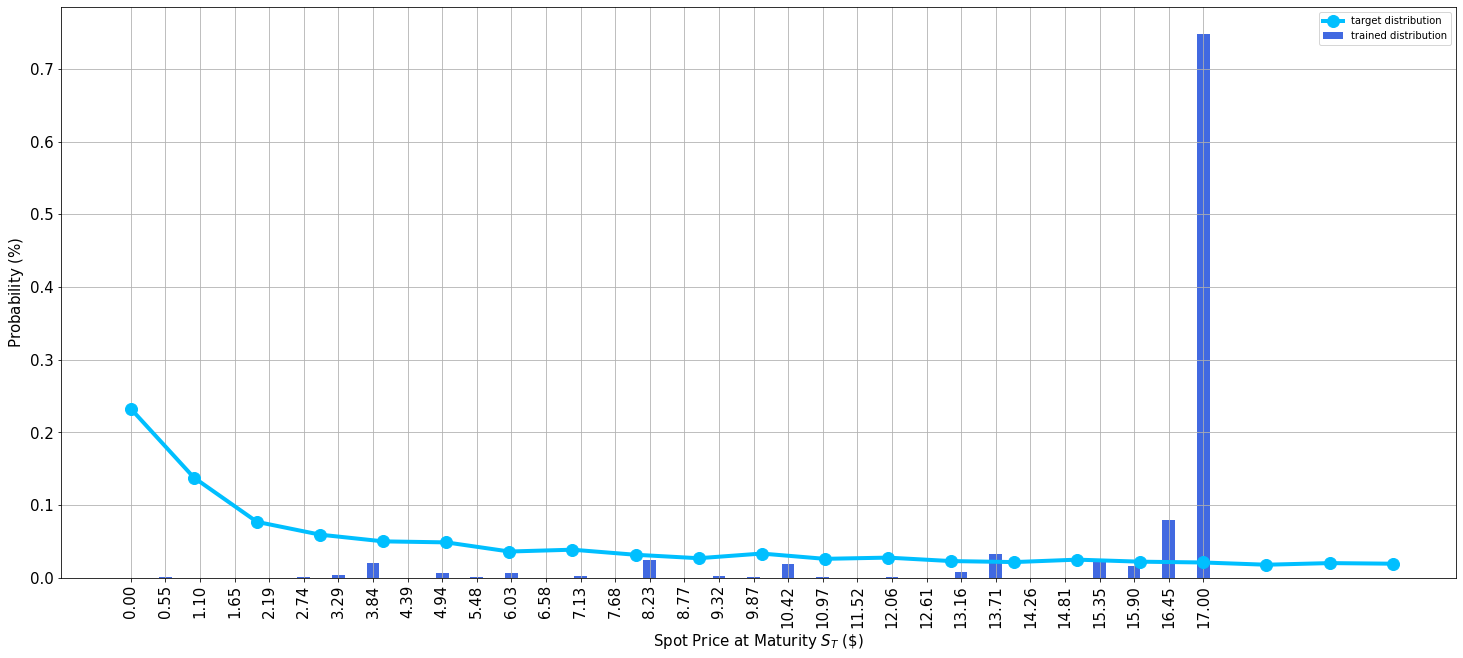

In [28]:
# evaluaethe training

values = [bounds[0] + (bounds[1] - bounds[0]) * x / (2**num_qubits - 1) for x in range(2**num_qubits)]
uncertainty_model = g_circuit.assign_parameters(dict(zip(theta, g_params)))
amplitudes = Statevector.from_instruction(uncertainty_model).data

x = np.array(values)
y = np.abs(amplitudes) ** 2

# Sample from target probability distribution
N = 100000
log_normal = np.random.lognormal(mean=14.25, sigma=6.25, size=N)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= 20]
log_normal_samples = []
for i in range(21):
    log_normal_samples += [np.sum(log_normal == i)]
log_normal_samples = np.array(log_normal_samples / sum(log_normal_samples))

# Plot distributions
plt.bar(x, y, width=0.2, label="trained distribution", color="royalblue")
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.plot(
    log_normal_samples,
    "-o",
    color="deepskyblue",
    label="target distribution",
    linewidth=4,
    markersize=12,
)
plt.legend(loc="best")
plt.show()


In [29]:
log_normal_samples

array([0.23268156, 0.13798883, 0.07709497, 0.05949721, 0.05027933,
       0.04888268, 0.03631285, 0.03882682, 0.03184358, 0.02709497,
       0.03351955, 0.02625698, 0.02793296, 0.02318436, 0.02178771,
       0.02513966, 0.02234637, 0.02122905, 0.01815642, 0.02039106,
       0.01955307])

In [30]:
payoff = np.array([0, 0, 0, 1, 2, 3, 4, 5, 6, 7,8,9, 10, 1, 3, 5,6, 1,0,2,4])
payoff

array([ 0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  1,  3,  5,  6,
        1,  0,  2,  4])

In [31]:
len(log_normal_samples) == len(payoff)

True

In [32]:
ep = np.dot(log_normal_samples, payoff)

In [33]:
y

array([8.48046707e-05, 1.36865649e-03, 4.80903136e-05, 2.33846881e-05,
       2.49331756e-04, 7.61975521e-04, 4.10136592e-03, 2.02594552e-02,
       1.05029939e-06, 6.60702536e-03, 1.04425378e-03, 6.52639145e-03,
       2.89751444e-05, 2.60510073e-03, 5.16795758e-05, 2.52279440e-02,
       1.91483186e-04, 2.05344717e-03, 7.83899332e-04, 1.91334587e-02,
       9.06725784e-04, 5.35440033e-04, 8.64777217e-04, 6.82131186e-06,
       7.50561841e-03, 3.27430271e-02, 5.10625656e-04, 3.78177622e-08,
       2.26165930e-02, 1.63445781e-02, 7.92662414e-02, 7.47547741e-01])

## Complete Version

In [34]:
# Set upper and lower data values
bounds = np.array([0.0, 10.0])
# Set number of qubits used in the uncertainty model
num_qubits = 3

# Load the trained circuit parameters
g_params = [0.29399714, 0.38853322, 0.9557694, 0.07245791, 6.02626428, 0.13537225]

# Set an initial state for the generator circuit
init_dist = NormalDistribution(num_qubits, mu=6.0, sigma=2.25, bounds=bounds)

# construct the variational form
var_form = TwoLocal(num_qubits, "ry", "cz", entanglement="circular", reps=1)

# keep a list of the parameters so we can associate them to the list of numerical values
# (otherwise we need a dictionary)
theta = var_form.ordered_parameters

# compose the generator circuit, this is the circuit loading the uncertainty model
g_circuit = init_dist.compose(var_form)

## Evaluate Expected Payoff

In [35]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 6.12

# set the approximation scaling for the payoff function
c_approx = 0.25

## Plot the probability distribution

In [36]:
theta

[ParameterVectorElement(θ[0]),
 ParameterVectorElement(θ[1]),
 ParameterVectorElement(θ[2]),
 ParameterVectorElement(θ[3]),
 ParameterVectorElement(θ[4]),
 ParameterVectorElement(θ[5])]

In [37]:
amplitudes = Statevector.from_instruction(uncertainty_model).data
amplitudes

array([ 9.20894515e-03+0.j,  3.69953577e-02+0.j, -6.93471799e-03+0.j,
        4.83577172e-03+0.j, -1.57902424e-02+0.j, -2.76039041e-02+0.j,
        6.40419075e-02+0.j, -1.42335713e-01+0.j, -1.02484115e-03+0.j,
       -8.12836107e-02+0.j, -3.23149157e-02+0.j,  8.07860845e-02+0.j,
        5.38285653e-03+0.j,  5.10401874e-02+0.j, -7.18885080e-03+0.j,
        1.58833070e-01+0.j,  1.38377450e-02+0.j, -4.53149773e-02+0.j,
        2.79982023e-02+0.j,  1.38323746e-01+0.j, -3.01118878e-02+0.j,
        2.31395772e-02+0.j,  2.94070947e-02+0.j, -2.61176413e-03+0.j,
       -8.66349722e-02+0.j,  1.80950344e-01+0.j, -2.25970276e-02+0.j,
        1.94467895e-04+0.j,  1.50388141e-01+0.j, -1.27845916e-01+0.j,
       -2.81542610e-01+0.j, -8.64608432e-01+0.j])

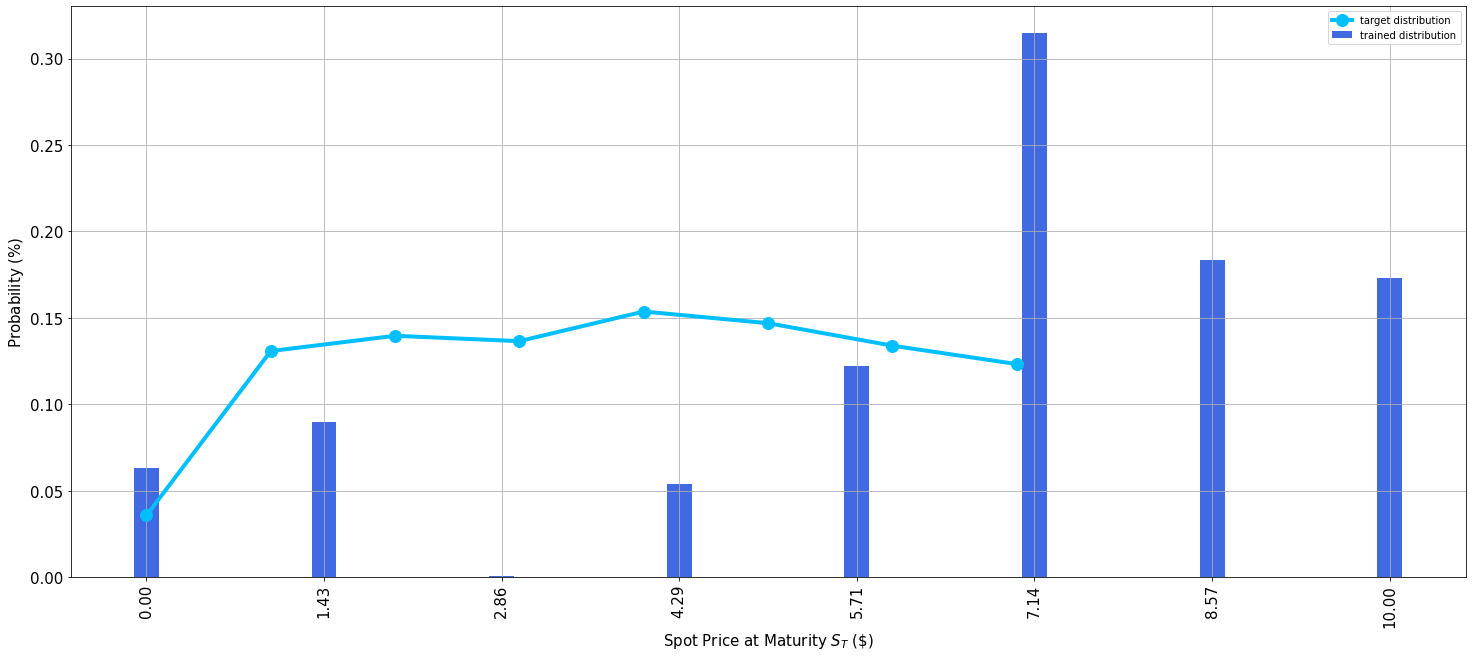

In [38]:
# Evaluate trained probability distribution
values = [
    bounds[0] + (bounds[1] - bounds[0]) * x / (2**num_qubits - 1) for x in range(2**num_qubits)
]
uncertainty_model = g_circuit.assign_parameters(dict(zip(theta, g_params)))
amplitudes = Statevector.from_instruction(uncertainty_model).data

x = np.array(values)
y = np.abs(amplitudes) ** 2

# Sample from target probability distribution
N = 100000
log_normal = np.random.lognormal(mean=6, sigma=2.25, size=N)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= 10]
log_normal_samples = []
for i in range(8):
    log_normal_samples += [np.sum(log_normal == i)]
log_normal_samples = np.array(log_normal_samples / sum(log_normal_samples))

# Plot distributions
plt.bar(x, y, width=0.2, label="trained distribution", color="royalblue")
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.plot(
    log_normal_samples,
    "-o",
    color="deepskyblue",
    label="target distribution",
    linewidth=4,
    markersize=12,
)
plt.legend(loc="best")
plt.show()

## Evaluate Expected Payoff

In [39]:
log_normal_samples

array([0.03561217, 0.13075123, 0.13958929, 0.13646998, 0.1536262 ,
       0.14686769, 0.13387055, 0.12321289])

In [40]:
y

array([0.06316744, 0.08976255, 0.00032328, 0.0539916 , 0.12216633,
       0.31450602, 0.18319289, 0.17288988])

Analytically calculated expected payoff w.r.t. the target distribution:  2.0359
Analytically calculated expected payoff w.r.t. the trained distribution: 2.8391


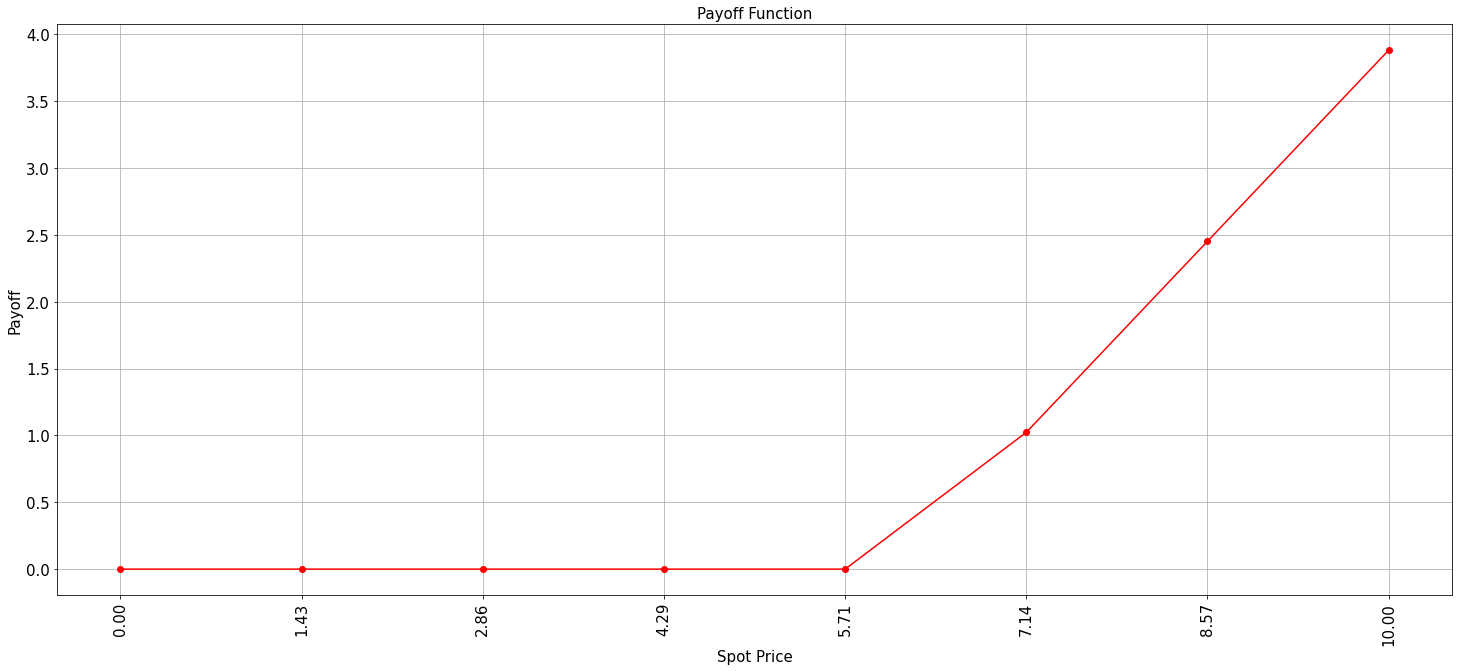

In [41]:
# Evaluate payoff for different distributions
payoff = np.array([0, 0, 0, 1, 2, 3, 4, 5])
ep = np.dot(log_normal_samples, payoff)
print("Analytically calculated expected payoff w.r.t. the target distribution:  %.4f" % ep)
ep_trained = np.dot(y, payoff)
print("Analytically calculated expected payoff w.r.t. the trained distribution: %.4f" % ep_trained)

# Plot exact payoff function (evaluated on the grid of the trained uncertainty model)
x = np.array(values)
y_strike = np.maximum(0, x - strike_price)
plt.plot(x, y_strike, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [42]:
log_normal_samples

array([0.03561217, 0.13075123, 0.13958929, 0.13646998, 0.1536262 ,
       0.14686769, 0.13387055, 0.12321289])

In [43]:
# construct circuit for payoff function
european_call_pricing = EuropeanCallPricing(
    num_qubits,
    strike_price=strike_price,
    rescaling_factor=c_approx,
    bounds=bounds,
    uncertainty_model=uncertainty_model,
)

In [44]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = european_call_pricing.to_estimation_problem()
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)

In [45]:
result = ae.estimate(problem)

In [46]:
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % ep_trained)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	2.8391
Estimated value:    	1.4520
Confidence interval:	[1.4015, 1.5025]


## Software Versions

In [47]:
import qiskit.tools.jupyter

%qiskit_version_table